In [175]:
# import libraries
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import requests
from keras.layers import TextVectorization

In [176]:
# get data files
url_train = 'https://cdn.freecodecamp.org/project-data/sms/train-data.tsv'
url_test = 'https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv'

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

#Since there are two url, let's create a function to download the file
def download_file(url, file_path):
    response = requests.get(url)
    with open (file_path, 'wb') as file:
        file.write(response.content)

download_file(url_train, train_file_path)
download_file(url_test, test_file_path)

train_data = pd.read_csv(train_file_path, sep='\t')
test_data = pd.read_csv(test_file_path, sep='\t')

# EDA

In [177]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4178 entries, 0 to 4177
Data columns (total 2 columns):
 #   Column                                                                                                                                              Non-Null Count  Dtype 
---  ------                                                                                                                                              --------------  ----- 
 0   ham                                                                                                                                                 4178 non-null   object
 1   ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it.  4178 non-null   object
dtypes: object(2)
memory usage: 65.4+ KB


In [178]:
train_data.head()

,ham,"ahhhh...just woken up!had a bad dream about u tho,so i dont like u right now :) i didnt know anything about comedy night but i guess im up for it."
0,ham,you can never do nothing
1,ham,"now u sound like manky scouse boy steve,like! ..."
2,ham,mum say we wan to go then go... then she can s...
3,ham,never y lei... i v lazy... got wat? dat day ü ...
4,ham,in xam hall boy asked girl tell me the startin...


In [179]:
# Since the dataset has no column names, I'll set it
df_train = pd.read_csv(train_file_path, sep='\t', header = None, names=['classification', 'text'])
df_test = pd.read_csv(test_file_path, sep='\t', header = None, names=['classification', 'text'])

In [180]:
df_train.head()

,classification,text
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [181]:
# add a column "class" encoding the classification, "0" for "ham" and "1" for "spam" 

df_train['class'] = df_train['classification'].map({'ham': 0, 'spam':1})
df_test['class'] = df_test['classification'].map({'ham': 0, 'spam':1})

<Axes: xlabel='classification'>

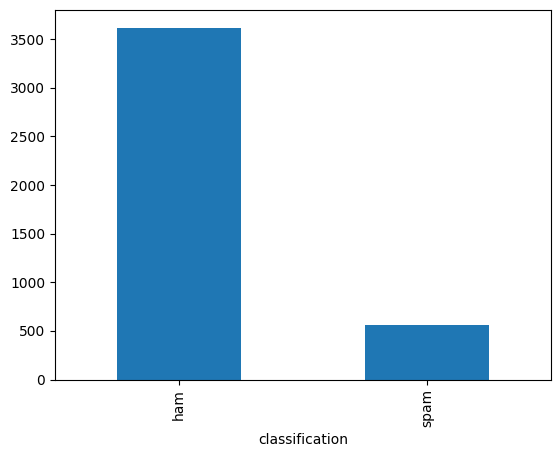

In [182]:
# let's see the frequence of ham and spam messages in both datasets

classification_counter = df_train['classification'].value_counts()
#classification_counter = df_test['classification'].value_counts()
classification_counter.plot(kind='bar')

# Model

In [183]:
X_train = df_train['text']
y_train = df_train['class']
X_test = df_test['text']
y_test = df_test['class']

In [184]:
# Create an instance of the encoder to encode the sms Texts

#Defining the encoder
encoder = tf.keras.layers.TextVectorization(
    standardize = None,
)

#set the encoder vocabulary with .adapt
encoder.adapt(df_train['text'])

In [185]:
encoded_texts = encoder(df_train['text'][:5])
encoded_texts

<tf.Tensor: shape=(5, 30), dtype=int64, numpy=
array([[10502,  2822,  4977,     5,   460,   897,    77,     7,  5250,
            3,    89,    50,     7,   185,    51,   203,     3,   422,
           55,   190,    77,  2573,   134,    23,     3,   312,   137,
           43,    12,   208],
       [    4,    28,   242,    30,   414,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [   51,     7,  1198,    50,  7457,  6024,   490,  5577,     3,
           10,  5115,    18,   149,   458,  8247,    97,     7,  8071,
           46,  6301,   403,  2514,     0,     0,     0,     0,     0,
            0,     0,     0],
       [  872,   131,    38,   239,     2,    41,    59,  8559,    59,
           86,    28,  5855, 10116,   317,   149,  8567,  8941,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
           

In [208]:
model = tf.keras.Sequential([
    encoder,  # TextVectorization layer
    keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()), 
        output_dim=32  # Embedding dimensions
    ),
    keras.layers.LSTM(32),
    keras.layers.Dense(1, activation='sigmoid')  # For binary classification
])

In [209]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [210]:
model.fit(X_train, y_train)

131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8343 - loss: 0.4252


In [211]:
model.evaluate(X_test, y_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9475 - loss: 0.2017


[0.20382434129714966, 0.9475574493408203]

In [241]:
# function to predict messages based on model
# (should return list containing prediction and label, ex. [0.008318834938108921, 'ham'])
def predict_message(pred_text):
  
  prediction = [] #declaring prediction as an empty string

  series_pred_text = pd.Series(pred_text) #converting the text in a series to feed the model
  prediction_first_element = model.predict(series_pred_text)

  prediction.append(prediction_first_element[0][0])

  if prediction_first_element[0][0] < 0.5:
    prediction.append('ham')
  else:
    prediction.append('spam')

  return (prediction)

pred_text = "how are you doing today?"

prediction = predict_message(pred_text)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[0.42294374, 'ham']


# Testing the model predicitons

In [242]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
You passed the challenge. Great job!
